# Probabilistic Programming - 2

## Monte Carlo sampling

In this notebook, we are exploring a more complex problem set using Monte Carlo sampling. We will look at how to specify a model and run a sampling procedure for a mixture model. 

### Preliminaries

- Goal 
  - Write a variational inference procedure for a mixture model
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - Cheatsheets: how does Julia differ from Matlab / Python (https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).
    - Tutorials using Turing.jl (https://turing.ml/dev/tutorials/0-introduction/)

## Mixture modeling

We will first generate a synthetic data set to play around. This will let us focus on the data-generating process and on the point that a good model should follow the data-generating process.

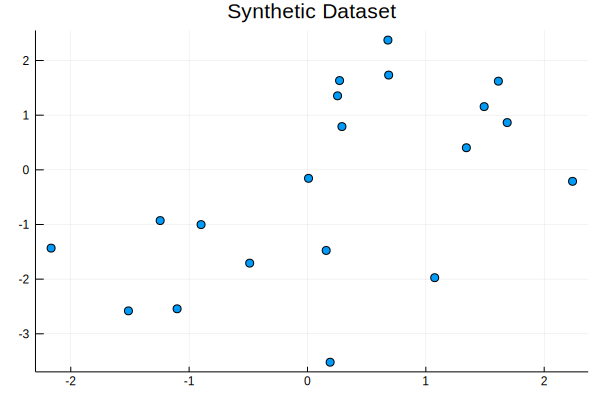

In [1]:
using Distributions
using StatsPlots
using Random
using Revise

# Set a random seed.
Random.seed!(3)

# Construct 10 data points for each cluster.
N = 10

# Means for each cluster, assuming each cluster is Gaussian distributed
μ1 = [-1, -1]
μ2 = [+1, +1]

# Concatenate means
μs = [μ1 μ2]

# Construct the data points.
X = mapreduce(c -> rand(MvNormal(μs[:, c], 1.), N), hcat, 1:2)

# Visualization.
scatter(X[1,:], X[2,:], legend = false, title = "Synthetic Dataset")

### Monte Carlo Sampling

With MC sampling, we obtain samples from the posterior distribution and approximate its distribution.

In [2]:
using Turing
using MCMCChains
Turing.setadbackend(:forward_diff);
include("scripts/ppl-2.jl")

┌ Info: Recompiling stale cache file /home/wmkouw/.julia/compiled/v1.1/Turing/gm4QC.ji for Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1184


In [3]:
@model GaussianMixtureModel(x, m1, m2) = begin
    
    D, N = size(x)

    # Draw the mean for cluster 1 [2x1 vector]
    μ1 ~ MvNormal(m1, 1.)
    
    # Draw the mean for cluster 2 [2x1 vector]
    μ2 ~ MvNormal(m2, 1.)
    
    # Concatenate means [2x2 matrix]
    μ = [μ1 μ2]
    
    # Probability of belonging to each cluster [2x1 vector]
    w = [0.5, 0.5]
    
    # Preallocate assignment vector [Nx1 vector]
    k = Vector{Int}(undef, N)
    
    # Loop over observations
    for i in 1:N
        
        # Draw assignment for i-th sample from a Categorical distribution parameterized by w
        k[i] ~ Categorical(w)
        
        # Data point x[i] follows a normal distribution, with mean indexed by the assignment variable k[i]
        x[:,i] ~ MvNormal(μ[:, k[i]], 1.)
    end
    
    # Return the assignments
    return k
end

GaussianMixtureModel (generic function with 4 methods)

In [4]:
# Set priors
m1 = [-2, -2]
m2 = [0, 0]

# Create an instance of a model, using the synthetic data set X
gmm_model = GaussianMixtureModel(X, m1, m2);

We now have a data set and a model. To arrive at class assignments for each data point, we need to perform inference. As stated before, there are two main schools of thought in Bayesian inference: Monte Carlo sampling and variational approximations. Below, we will use a particular form of Monte Carlo sampling, called Gibbs sampling.

In [5]:
# Construct Gibbs sampler
gmm_sampler = Gibbs(PG(100, :k), HMC(0.05, 10, :μ1, :μ2))

# Start sampling
tchain = mapreduce(c -> sample(gmm_model, gmm_sampler, 100), chainscat, 1);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


In [6]:
# Extract the means over the MCMC chains for the posterior means
μ1_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ1].value.data[:,:,1]; dims=1)));
μ2_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ2].value.data[:,:,1]; dims=1)));

# Report differences between estimated mean and true means
println("Difference between μ1 and μ1_estimated = "*string(abs.(μ1 - μ1_estimated)))
println("Difference between μ2 and μ2_estimated = "*string(abs.(μ2 - μ2_estimated)))

Difference between μ1 and μ1_estimated = [0.221911, 0.863137]
Difference between μ2 and μ2_estimated = [0.128853, 0.0113927]


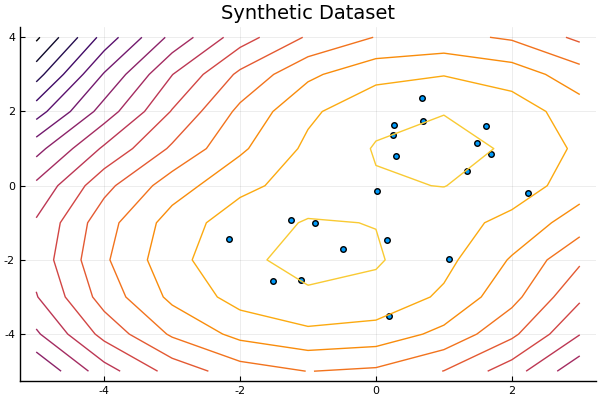

In [7]:
# Plot data and overlay estimated posterior probabilities
plot_posteriors(X, μ1_estimated, μ2_estimated)

Let's take a closer look at the chain. 

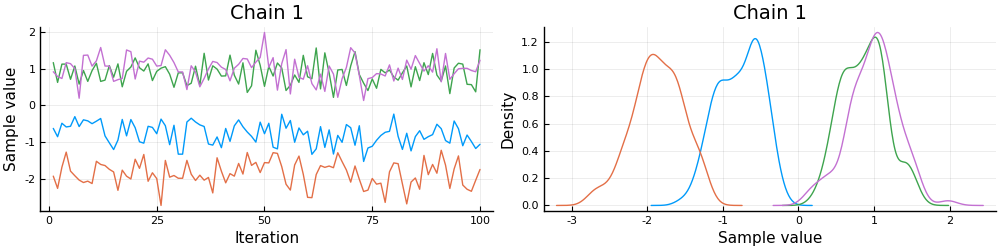

In [8]:
# Find the means within the chain
ids = findall(map(name -> occursin("μ", name), names(tchain)));

# Plot the course of the chains
p=plot(tchain[:, ids, :], labels = ["mu_11" "mu_12" "mu_21" "mu_22"], colordim=:parameter)

### A real-world problem

Let's have another look at the Old Faithful data set. Can we model it in the same way?

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[9]:7
└ @ Core In[9]:7
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[9]:7
└ @ Core In[9]:7


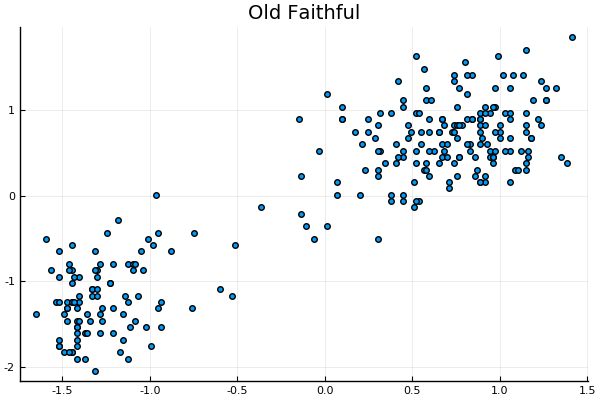

In [9]:
using DataFrames
using CSV
using LinearAlgebra

# Read file
old_faithful = CSV.read("datasets/old_faithful.csv")

# Convert file to matrix
X = convert(Matrix{Float64}, [old_faithful[1] old_faithful[2]])

# Center the data
X = X .- mean(X, dims=1)

# Normalize by standard deviation
X = X ./ std(X, dims=1)

# Scatter data points
scatter(X[:,1], X[:,2], legend=false, title="Old Faithful")

First of all, we should specify the model that we believe generated the data. 

In [10]:
# Set priors
m1 = [-1, -1]
m2 = [+1, +1]

# Call another instance of the model for this data set
gmm_model = GaussianMixtureModel(X', m1, m2);

# Construct Gibbs sampler
gmm_sampler = Gibbs(PG(100, :k), HMC(0.05, 10, :μ1, :μ2))

# Start sampling
tchain = mapreduce(c -> sample(gmm_model, gmm_sampler, 100), chainscat, 1);

Progress: 100%|█████████████████████████████████████████| Time: 1:24:18


As you may start to realize, sampling is slow.

In [11]:
# Means of distributions
μ1_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ1].value.data[:,:,1]; dims=1)));
μ2_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ2].value.data[:,:,1]; dims=1)));

# Report estimated mean for each cluster
println("μ1_estimated = "*string(μ1_estimated))
println("μ2_estimated = "*string(μ2_estimated))

μ1_estimated = [-0.710479, -0.674779]
μ2_estimated = [1.01469, 0.408122]


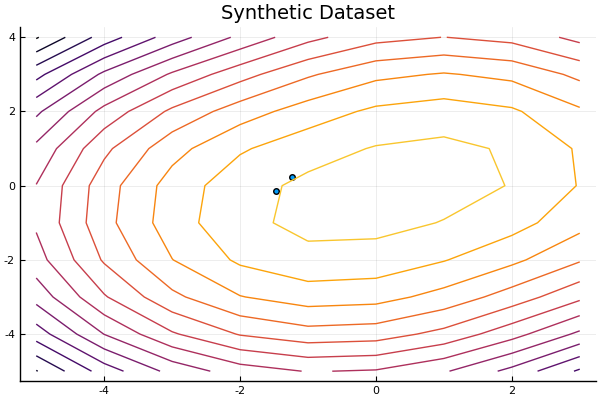

In [12]:
# # Plot iso-probability lines
# x1 = range(-3, stop = 3)
# x2 = range(-3, stop = 3)

# # Scatter points
# scatter(X[:, 1], X[:,2], legend=false, title="Fit of model on Old Faithful")
# contour!(x1, x2, (x, y) -> predict(x, y, [0.5, 0.5], μ1_estimated, μ2_estimated))

# Plot data and overlay estimated posterior probabilities
plot_posteriors(X, μ1_estimated, μ2_estimated)

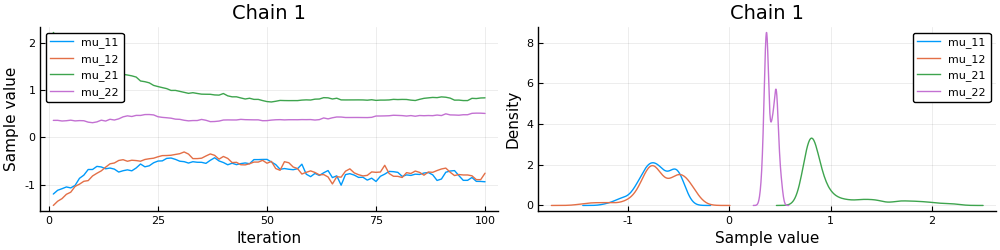

In [13]:
# Find the means within the chain
ids = findall(map(name -> occursin("μ", name), names(tchain)));

# Plot the course of the chains
p=plot(tchain[:, ids, :], legend=true, labels = ["mu_11" "mu_12" "mu_21" "mu_22"], colordim=:parameter)